# Molecular mechnism of earliest and fastest appearance of megakaryocytes

One intriguing phenomenon observed in hematopoiesis is that commitment to and appearance of the Meg lineage occurs more rapidly than other lineages (Sanjuan-Pla et al., 2013; Yamamoto et al., 2013). However, the mechanisms underlying this process remain elusive. To mechanistically dissect this finding, we focused on all cell types derived from the MEP-like lineage.

In this tutorial, we will guide you to
- visualize topography with computed fixed points and manually filtered fixed points
- visualize vector field pseudotime


Import relevant packages

In [20]:
%%capture

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import Scribe as sb
import sys
import os

# import scanpy as sc
import dynamo as dyn
import seaborn as sns

dyn.dynamo_logger.main_silence()

# filter warnings for cleaner tutorials
import warnings
warnings.filterwarnings('ignore')


In [21]:
adata_labeling = dyn.sample_data.hematopoiesis()


take a glance at what is in `adata` object. All observations, embedding layers and other data in `adata` are computed within `dynamo`. Please refer to other dynamo tutorials regarding how to obtain these values from metadata and raw new/total and (or) raw spliced/unspliced gene expression values.

## Schematic of leveraging differential geometry 
- ranking genes (using either raw or absolute values) across all cells or in each cell group/state
- gene set enrichment, network construction, and visualization
- identifying top toggle-switch pairs driving cell fate bifurcations

![fig5_A](images/fig5_a.png)

## Visualize topography


### Lineage tree of hematopoiesis, lumped automatically from the vector field built in the UMAP space

![fig5_C](images/fig5_C.png)


### The reconstructed vector field and associated fixed points. 
The color of digits in each node reflects the type of fixed point: red, emitting fixed point; black, absorbing fixed point. The color of the numbered nodes corresponds to the confidence of the fixed points.

#### Manually select good fixed points found by topography

In [22]:
adata_labeling.uns['VecFld_umap'].keys()

dict_keys(['C', 'E_traj', 'P', 'V', 'VFCIndex', 'X', 'X_ctrl', 'X_data', 'Xss', 'Y', 'beta', 'confidence', 'ctrl_idx', 'ftype', 'grid', 'grid_V', 'iteration', 'method', 'nullcline', 'sigma2', 'tecr_traj', 'valid_ind', 'xlim', 'ylim'])

In [75]:
dyn.vf.topography(adata_labeling, n=750, basis='umap');


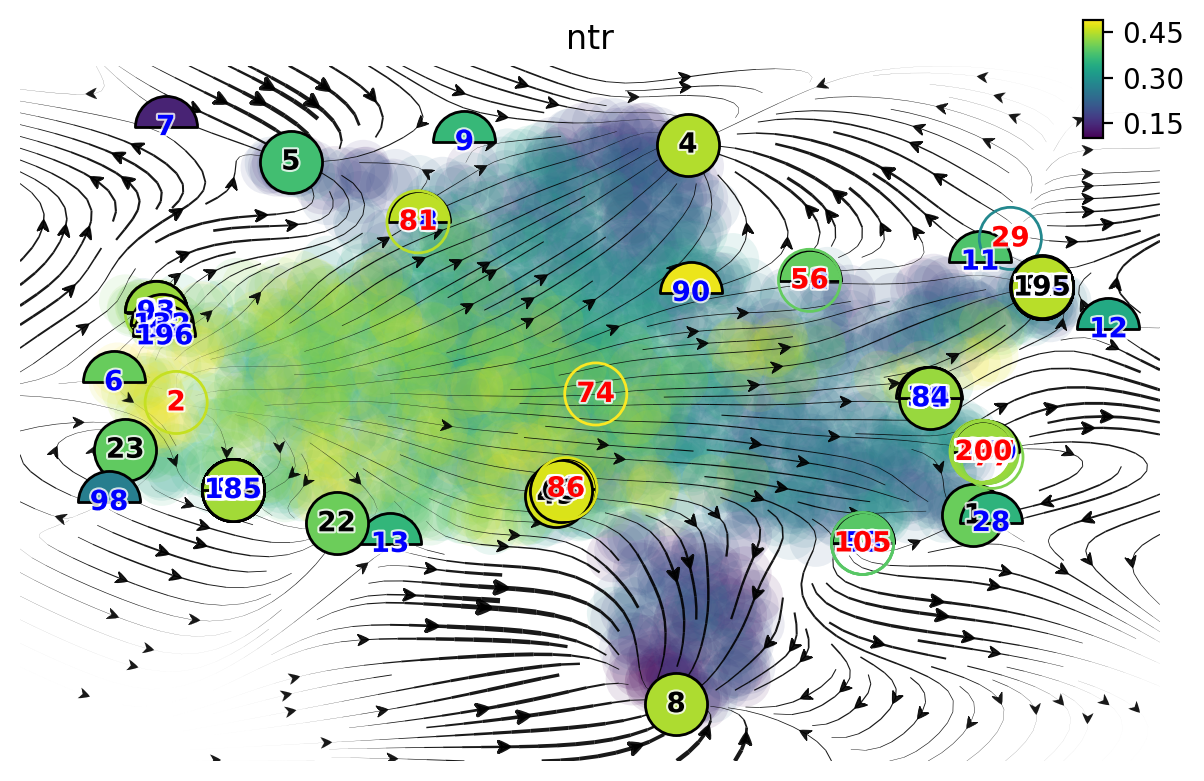

In [76]:
dyn.pl.topography(
    adata_labeling,
    markersize=500,
    basis="umap",
    fps_basis="umap",
    streamline_alpha=0.9,
)

In the resulted dictionary, `Xss` stands for the fixed points coordinates and `ftype` is the specific fixed point type, denoted by integers.  
ftype value mapping:  
- -1: stable
- 0: saddle
- 1: unstable

In [77]:
Xss, ftype = adata_labeling.uns['VecFld_umap']['Xss'], adata_labeling.uns['VecFld_umap']['ftype']
# good_fixed_points = [0, 2, 5, 29, 11, 28] # n=250
good_fixed_points = [2, 8, 1, 195, 4, 5] # n=750

adata_labeling.uns['VecFld_umap']['Xss'] = Xss[good_fixed_points]
adata_labeling.uns['VecFld_umap']['ftype'] = ftype[good_fixed_points]


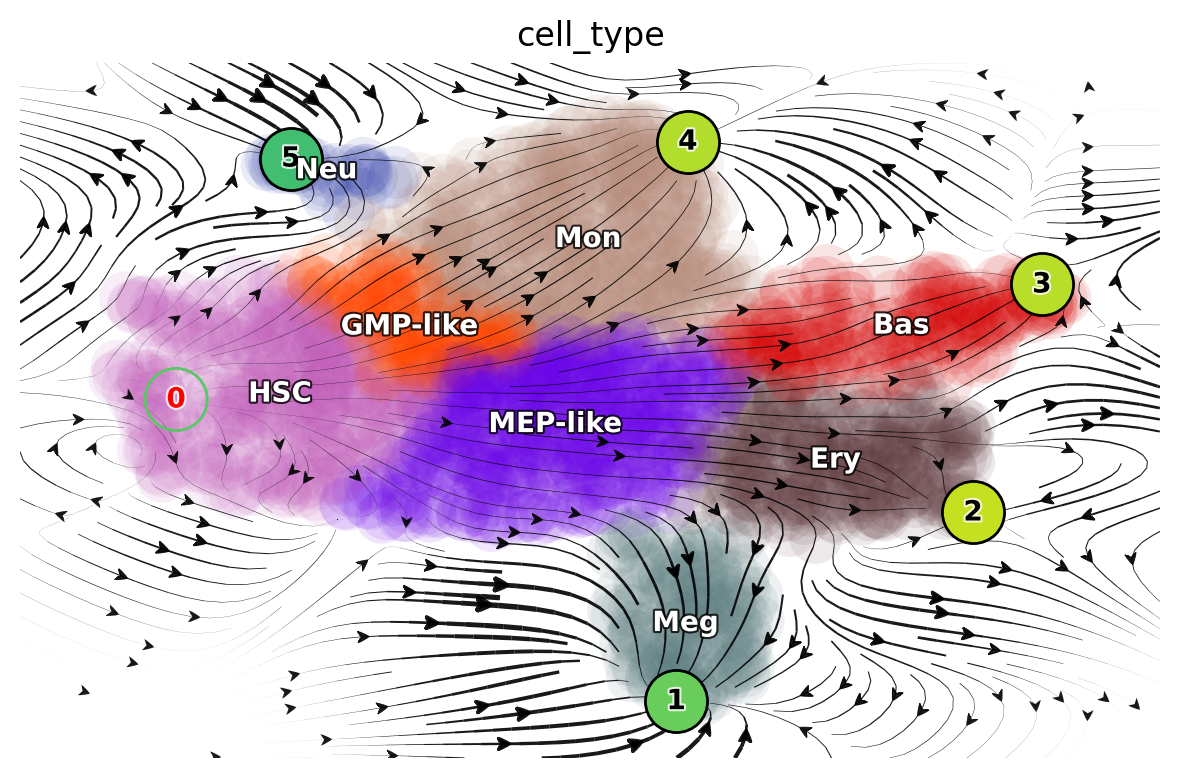

In [78]:
dyn.pl.topography(
    adata_labeling,
    markersize=500,
    basis="umap",
    fps_basis="umap",
    #   color=['pca_ddhodge_potential'],
    color=["cell_type"],
    streamline_alpha=0.9,
)


## Vector field pseudotime

In this section, we will show how to visualize vector field pseudotime with `dynamo`. The vector field pseudotime is calculated based on the velocity transition matrix.

**Define a colormap we will use later**

In [27]:
dynamo_color_dict = {
    "Mon": "#b88c7a",
    "Meg": "#5b7d80",
    "MEP-like": "#6c05e8",
    "Ery": "#5d373b",
    "Bas": "#d70000",
    "GMP-like": "#ff4600",
    "HSC": "#c35dbb",
    "Neu": "#2f3ea8",
}


**Initialize a Dataframe object that we will use to plot with visualization packages such as `sns`**

In [28]:
valid_cell_type = ["HSC", "MEP-like", "Meg", "Ery", "Bas"]
valid_indices = adata_labeling.obs["cell_type"].isin(valid_cell_type)
df = adata_labeling[valid_indices].obs[["pca_ddhodge_potential", "umap_ddhodge_potential", "cell_type"]]
df["cell_type"] = list(df["cell_type"])

### Building a graph, computing divergence and potential with `graph_operators` in `dynamo`

In [29]:
from dynamo.tools.graph_operators import build_graph, div, potential
g = build_graph(adata_labeling.obsp["cosine_transition_matrix"])
ddhodge_div = div(g)
potential_cosine = potential(g, -ddhodge_div)
adata_labeling.obs["cosine_potential"] = potential_cosine


Compute `potential_fp` and store in the dataframe object `df` we created above. Note that `fp` stands for `fokkerplanck` method. Please refer to the `dynamo` cell paper for more details on the related methods.

In [49]:
g = build_graph(adata_labeling.obsp["fp_transition_rate"])
ddhodge_div = div(g)
potential_fp = potential(g, ddhodge_div)

set `potential_fp` and `pseudotime_fp` in adata.obs to visualize potential and time.

In [50]:
adata_labeling.obs["potential_fp"] = potential_fp
adata_labeling.obs["pseudotime_fp"] = -potential_fp

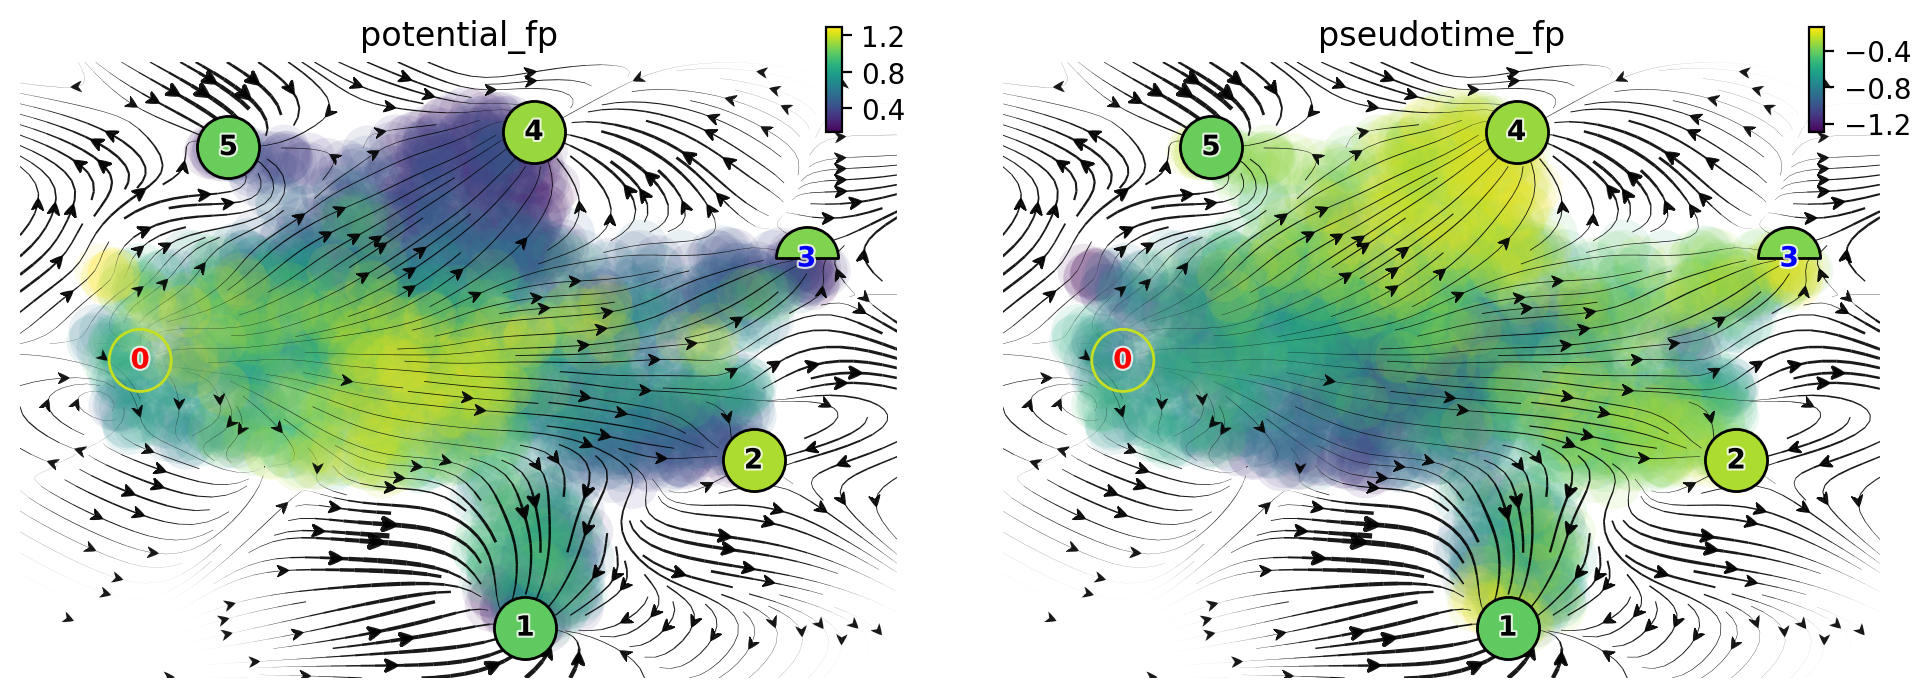

In [51]:
dyn.pl.topography(
    adata_labeling,
    markersize=500,
    basis="umap",
    fps_basis="umap",
    color=["potential_fp", "pseudotime_fp"],
    streamline_alpha=0.9,
)

Text(0.5, 9.444444444444438, 'vector field pseudotime')

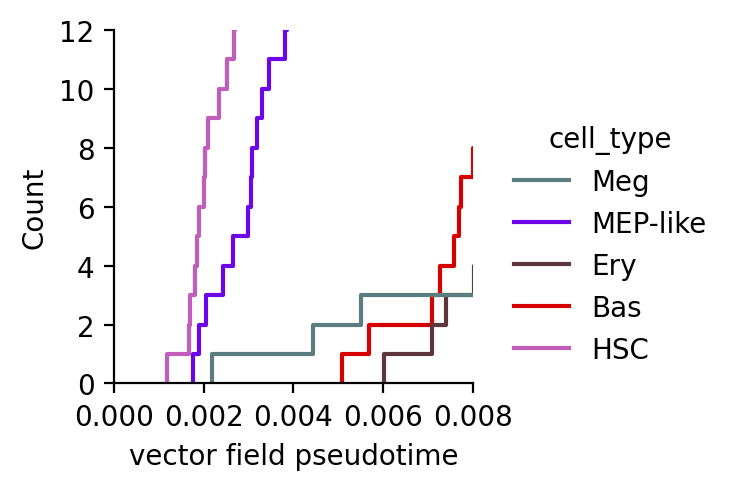

In [69]:
df["cosine"] = potential_cosine[valid_indices]
df["fp"] = potential_fp[valid_indices]
sns.displot(
    data=df,
    x="cosine",
    hue="cell_type",
    kind="ecdf",
    stat="count",
    palette=dynamo_color_dict,
    height=2.5,
    aspect=95.5 / 88.8,
)
plt.xlim(0.0, 0.008)
plt.ylim(0, 12)
plt.xlabel("vector field pseudotime")


Via the visualization results above from vectorfield analysis, we can observe that egakaryocytes appear earliest among the Meg, Ery, and Bas lineages. 

## Molecular mechanisms underlying the early appearance of the Meg lineage

In this section, we will show:
- Self- activation of FLI1
- Repression of KLF1 by FLI1
- FLI1 represses KLF1
- Schematic summarizing the interactions involving FLI1 and KLF1.

In [70]:
Meg_genes = ["FLI1", "KLF1"]

Compute jacobian of selected genes

In [32]:
dyn.vf.jacobian(adata_labeling, regulators=Meg_genes, effectors=Meg_genes);


Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 120423.96it/s]


Next we use jacobian analyses to reveal mutual inhibition between FLI1 and KLF1 (Figure 5F) and self-activation of FLI1.

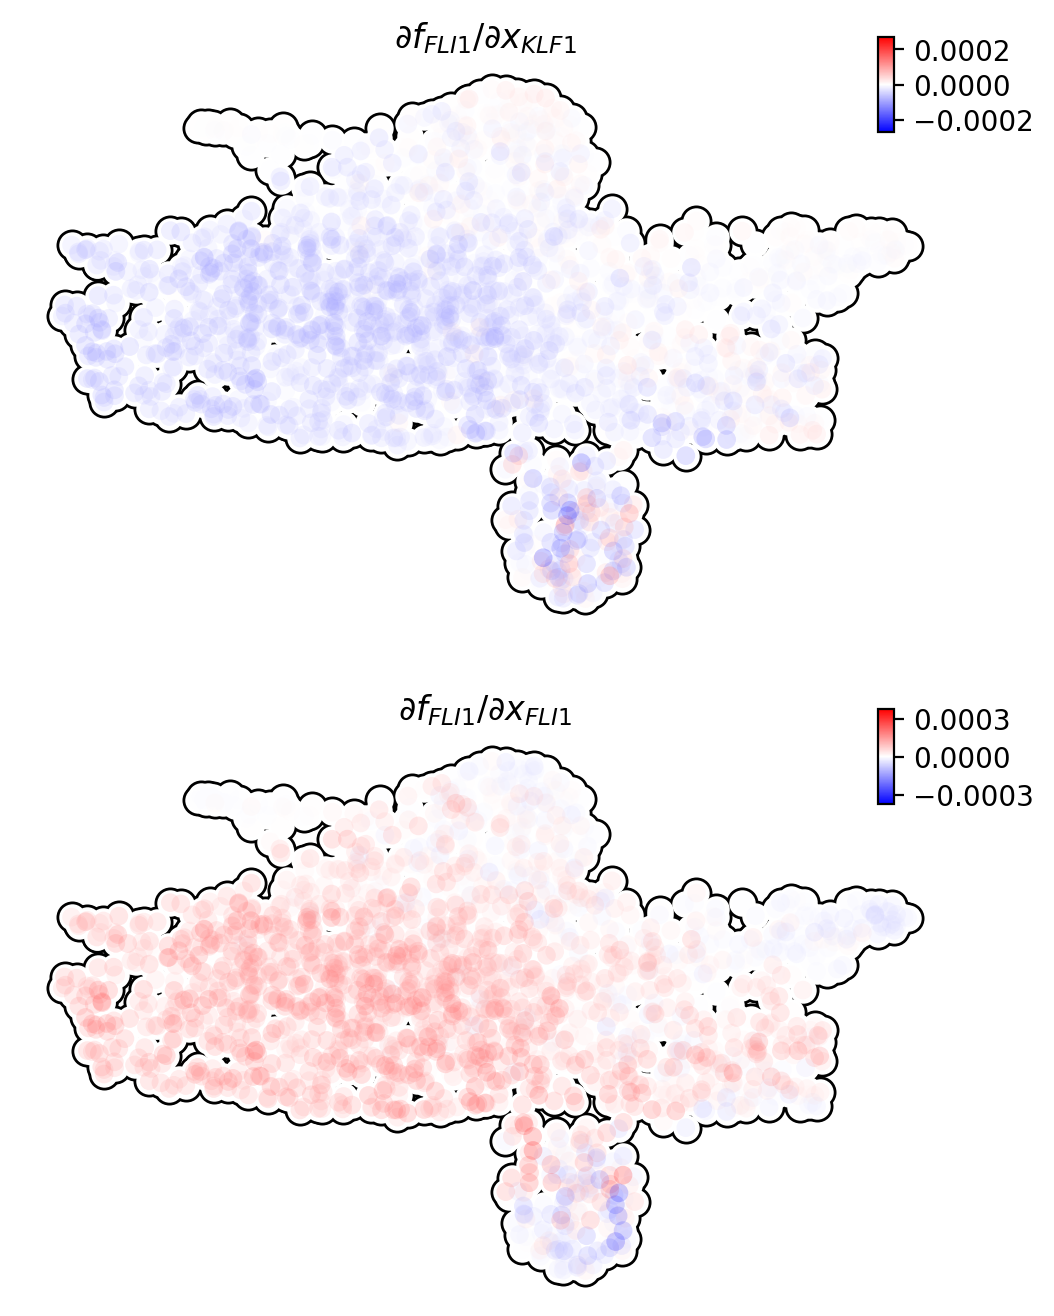

In [87]:

dyn.pl.jacobian(
    adata_labeling,
    regulators=Meg_genes,
    effectors=["FLI1"],
    basis="umap",
)

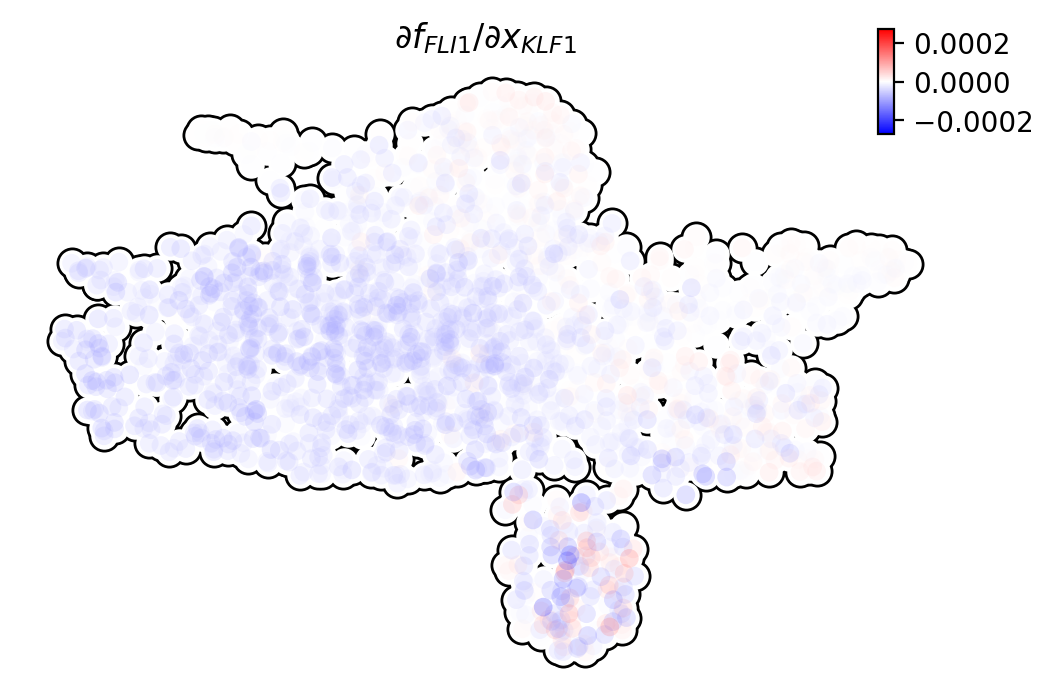

In [88]:
dyn.pl.jacobian(
    adata_labeling,
    regulators=["KLF1"],
    effectors=["FLI1"],
    basis="umap",
)

### Conclusion: schematic summarizing the interactions involving FLI1 and KLF1
Analyses above collectively suggest self-activation of FLI1 maintains its higher expression in the HSPC state, which biases the HSPCs to first commit towards the Meg lineage with high speed and acceleration, while repressing the commitment into erythrocytes through inhibition of KLF1. Together with the mutual regulation we show ealier in this tutorial, we can generate the following schematic to summarize the gene    network. 



![fig5_f_iv](images/fig5_f_iv.png)